<a href="https://colab.research.google.com/github/codeninja404/deep_learning_models_from_scratch/blob/main/soham_custom_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas
from keras import backend as K
from matplotlib import pyplot
import numpy as np

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

170500096/170498071 [==============================] - 3s 0us/step


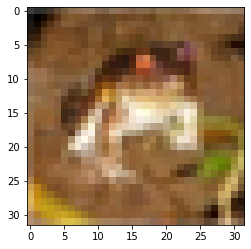

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [ ]:
x = np.expand_dims(x_train[0], axis = 0)
x.shape

(1, 32, 32, 3)

In [ ]:
def train_preprocess(image, label):
    image  = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image  = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    return image, label

def parse_data(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [ ]:
batch_size = 64
y_t = tf.keras.utils.to_categorical(y_train, 10)
data = tf.data.Dataset.from_tensor_slices((x_train, y_t))
data = data.shuffle(50000)
data = data.map(parse_data,num_parallel_calls= 4)
data = data.map(train_preprocess, num_parallel_calls=4)
data = data.padded_batch(batch_size)

In [ ]:
class conv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size,activation, **kwargs):
        self.out = filters
        self.kernel_size = kernel_size
        self.activation = tf.keras.layers.Activation(activation)
        super(conv,self).__init__(**kwargs)
        
    def build(self, input_shape):
        shape = list(self.kernel_size)+[input_shape[-1], self.out]
        self.kernel = self.add_weight(name = 'kernel', shape = shape, initializer = 'normal', trainable = True)
        super(conv,self).build(input_shape)
        
        
    def call(self, input_data):
        return self.activation(K.conv2d(input_data, self.kernel))
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]+(self.out,)

class maxpool2d(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(maxpool2d, self).__init__(**kwargs)
    def build(self, input_shape):
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = "valid")
        super(maxpool2d, self).build(input_shape)
    def call(self, x):
        x1 = self.maxpool(x)
        return x1
    
class Dense(tf.keras.layers.Layer):
    def __init__(self, units, activation):
        super(Dense, self).__init__()
        self.activation = tf.keras.layers.Activation(activation)
        self.units = units
    def build(self,input_shape):
        self.w = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]),
                                         self.units])
        
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

model_cus = tf.keras.models.Sequential([
    conv(64, (3,3), activation = 'relu', input_shape = (32,32,3)),
    maxpool2d(),
    conv(16,(3,3),activation = 'relu'),
    maxpool2d(),
    conv(16, (3,3), activation = 'relu', name = "intermediate_layer"),
    tf.keras.layers.Flatten(),
    Dense(512, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

model_cus.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (conv)                  (None, 30, 30, 64)        1728      
_________________________________________________________________
maxpool2d (maxpool2d)        (None, 15, 15, 64)        0         
_________________________________________________________________
conv_1 (conv)                (None, 13, 13, 16)        9216      
_________________________________________________________________
maxpool2d_1 (maxpool2d)      (None, 6, 6, 16)          0         
_________________________________________________________________
intermediate_layer (conv)    (None, 4, 4, 16)          2304      
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [ ]:
model_cus.compile(optimizer = "adam", 
              loss = 'CategoricalCrossentropy', 
              metrics = ['accuracy'])


In [ ]:
layer_ = [layer.output for layer in model_cus.layers]
activation_model = tf.keras.models.Model(inputs = model_cus.input, outputs = layer_)
activations = activation_model.predict(x)
model_cus.input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv_input')>

In [ ]:
first_layer_activation = activations[6]
print(first_layer_activation.shape)

(1, 512)


(1, 256)
(1, 256)
(1, 512)
(1, 512)
(1, 10)
(1, 10)


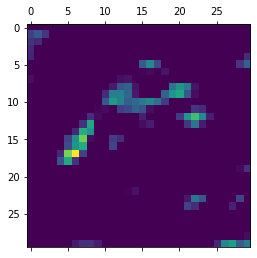

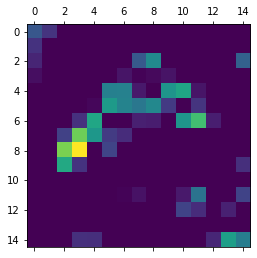

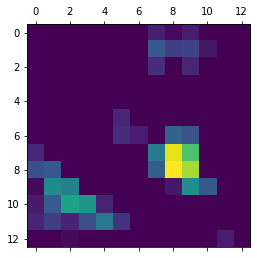

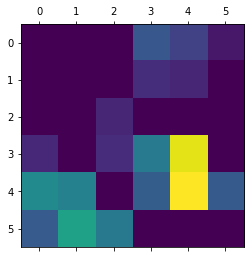

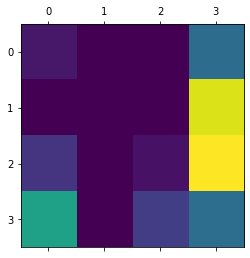

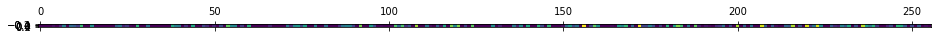

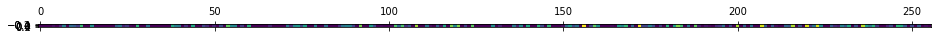

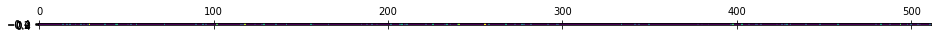

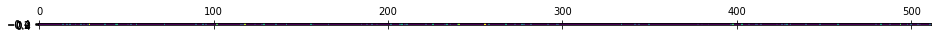

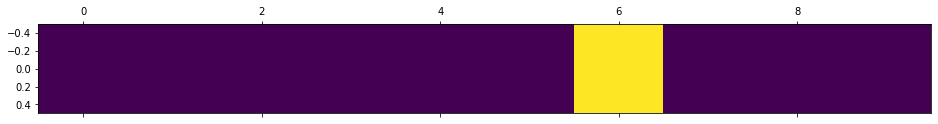

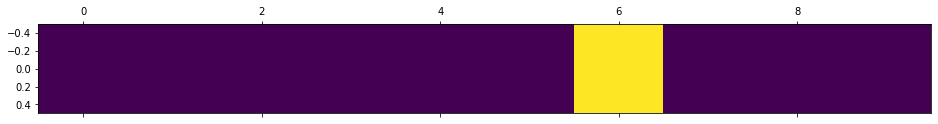

In [ ]:
for i in range(len(activations)):
    first_layer_activation = activations[i]
    for j in range(len(first_layer_activation.shape)):
        if j==3 :
            plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
        elif i > 4:
            print(first_layer_activation.shape)
            plt.matshow(first_layer_activation, cmap='viridis')

In [ ]:
layer_names = [layer.name for layer in model_cus.layers]

In [ ]:
for layer_name, feature_maps in zip(layer_names, activations):
    print(" the shape of {} ====> {}".format(layer_name , feature_maps.shape))

 the shape of conv ====> (1, 30, 30, 64)
 the shape of maxpool2d ====> (1, 15, 15, 64)
 the shape of conv_1 ====> (1, 13, 13, 16)
 the shape of maxpool2d_1 ====> (1, 6, 6, 16)
 the shape of intermediate_layer ====> (1, 4, 4, 16)
 the shape of flatten ====> (1, 256)
 the shape of dense ====> (1, 512)
 the shape of dense_1 ====> (1, 10)


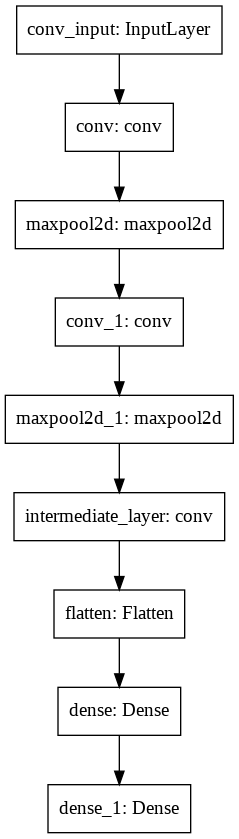

In [26]:
from keras.utils import plot_model
plot_model(model_cus)

In [28]:
history = model_cus.fit(data, epochs = 200, steps_per_epoch=100)

Epoch 1/200
100/100 [==============================] - 9s 86ms/step - loss: 0.8383 - accuracy: 0.7077
Epoch 2/200
100/100 [==============================] - 9s 87ms/step - loss: 0.8234 - accuracy: 0.7144
Epoch 3/200
100/100 [==============================] - 9s 86ms/step - loss: 0.8105 - accuracy: 0.7095
Epoch 4/200
100/100 [==============================] - 9s 86ms/step - loss: 0.7806 - accuracy: 0.7267
Epoch 5/200
100/100 [==============================] - 9s 87ms/step - loss: 0.7899 - accuracy: 0.7227
Epoch 6/200
100/100 [==============================] - 9s 85ms/step - loss: 0.8005 - accuracy: 0.7181
Epoch 7/200
100/100 [==============================] - 9s 87ms/step - loss: 0.7816 - accuracy: 0.7256
Epoch 8/200
100/100 [==============================] - 7s 70ms/step - loss: 0.7961 - accuracy: 0.7227


<function matplotlib.pyplot.show>

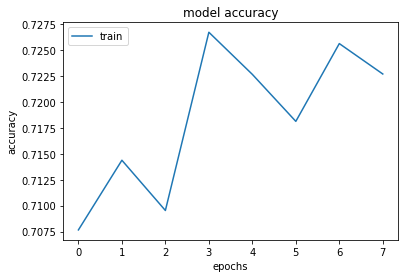

In [29]:
plt.plot(history.history['accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(['train'], loc = 'upper left')
plt.show

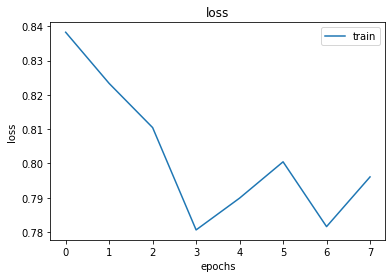

In [30]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel("epochs")
plt.legend(['train'], loc = "upper right")